In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_tree

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
df.describe(include = 'all')

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645,58645.000000,58645,58645,58645.000000,58645.000000,58645.000000,58645,58645.000000,58645.000000
unique,NaN,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,N,NaN,NaN
freq,NaN,NaN,NaN,30594,NaN,12271,20984,NaN,NaN,NaN,49943,NaN,NaN
mean,29322.000000,27.550857,6.404617e+04,NaN,4.701015,NaN,NaN,9217.556518,10.677874,0.159238,NaN,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,NaN,3.959784,NaN,NaN,5563.807384,3.034697,0.091692,NaN,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,NaN,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.880000,0.090000,NaN,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.750000,0.140000,NaN,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,NaN,7.000000,NaN,NaN,12000.000000,12.990000,0.210000,NaN,8.000000,0.000000


In [7]:
df.drop(columns='id', inplace = True)

In [8]:
df['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [9]:
df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [10]:
df['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

Tasks:
- Data cleaning
- EDA by visualization
- Replace `cb_person_default_on_file`: N to 0, Y to 1
- Encoding: __Label Encoding for `loan_grade`, `person_home_ownership`, `loan_intent`.__
- Apply feature scaling: standardization
- Feature Selection: Remove highly correlated features.
- Modeling: Logistic Regression, Decision Trees, Random Forest


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [12]:
df['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [13]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df_numeric = df.select_dtypes('int')

In [16]:
df_numeric.corr()['loan_status'].sort_values(ascending = False)

loan_status                   1.000000
loan_amnt                     0.144982
person_age                   -0.001130
cb_person_cred_hist_length   -0.003030
person_income                -0.169956
Name: loan_status, dtype: float64

In [17]:
df_numeric.columns

Index(['person_age', 'person_income', 'loan_amnt',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

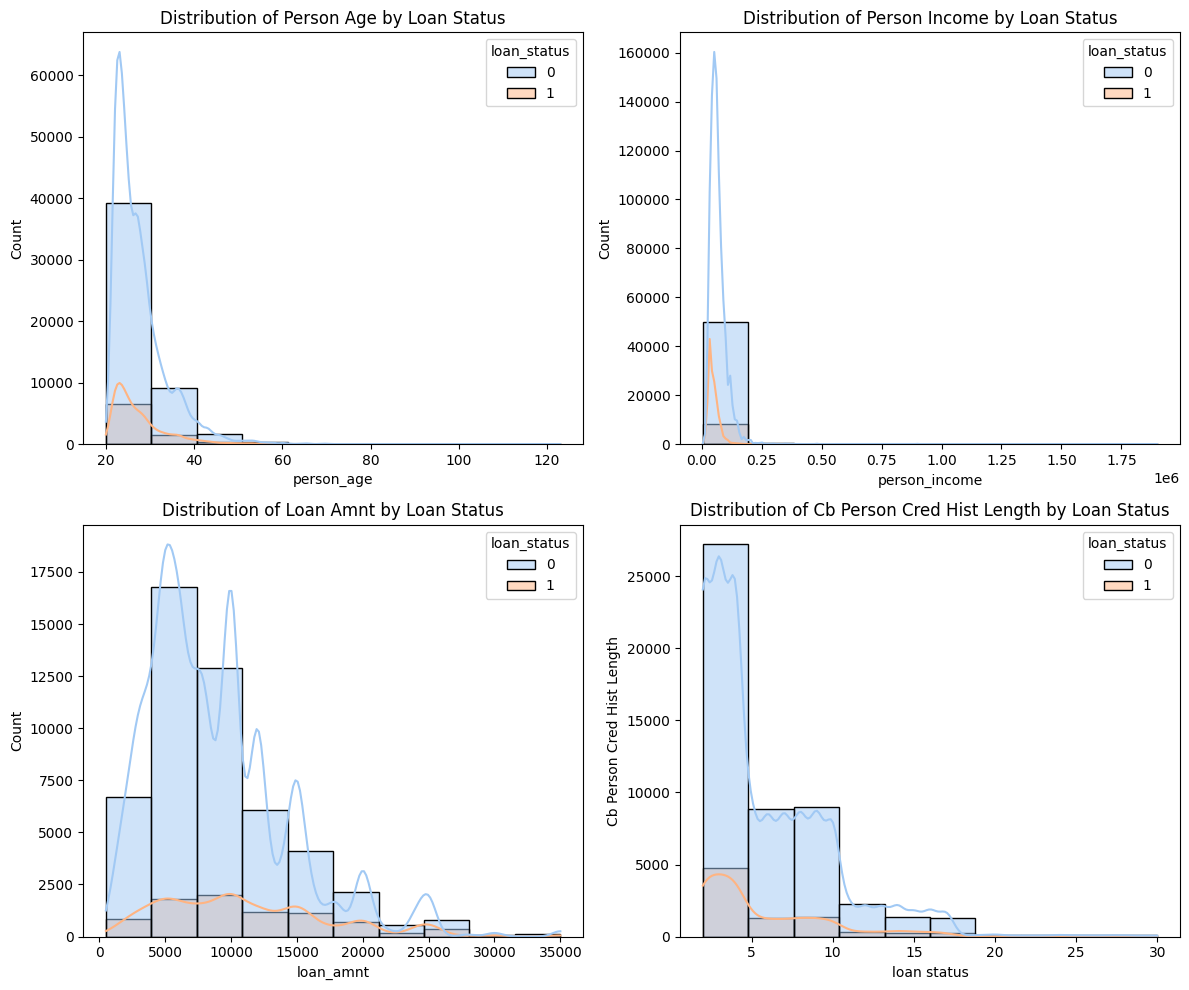

In [18]:
# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# List of columns to plot
columns = ['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']

# Loop through the columns and create histograms
for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, hue='loan_status', kde=True, ax=axes[i], palette='pastel', bins=10) 
        axes[i].set_title(f'Distribution of {col.replace("_", " ").title()} by Loan Status')

axes[i].set_xlabel('loan status')
axes[i].set_ylabel(col.replace("_", " ").title())
plt.tight_layout()
plt.show()

In [19]:
df_cat = df.select_dtypes('object')
df_cat.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

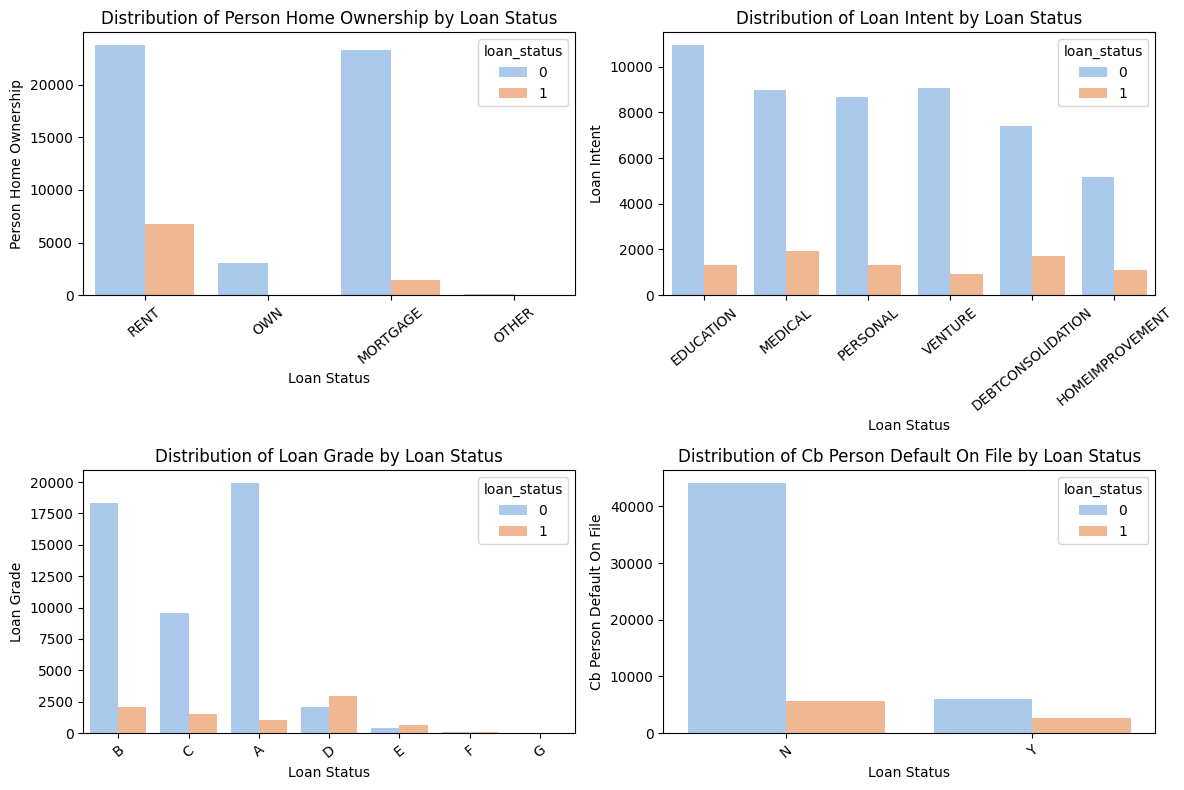

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# List of columns to plot
columns = ['person_home_ownership', 'loan_intent', 'loan_grade','cb_person_default_on_file']

# Loop through the columns and create histograms
for i, col in enumerate(columns):
        sns.countplot(data=df, x=col, hue='loan_status', ax=axes[i], palette='pastel')
        axes[i].set_title(f'Distribution of {col.replace("_", " ").title()} by Loan Status')
        axes[i].set_xlabel('Loan Status')
        axes[i].set_ylabel(col.replace("_", " ").title())
        axes[i].tick_params(axis='x', rotation=40)
plt.tight_layout()
plt.show()

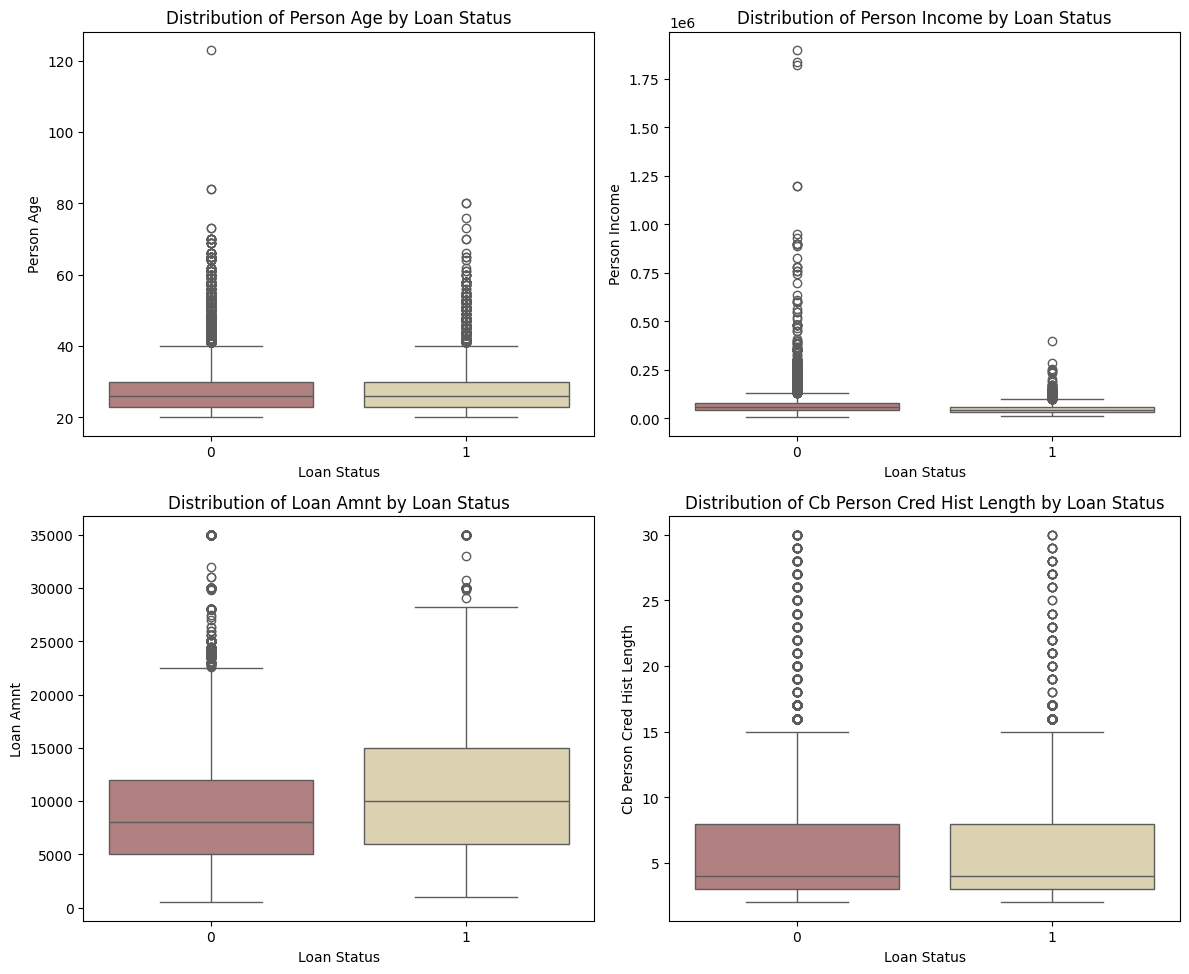

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
# List of columns to plot
columns = ['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']

# Loop through the columns and create boxplots
for i, col in enumerate(columns):
    sns.boxplot(data=df, x='loan_status', y=col, ax=axes[i], palette='pink')
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()} by Loan Status')
    axes[i].set_xlabel('Loan Status')
    axes[i].set_ylabel(col.replace("_", " ").title())

plt.tight_layout()
plt.show()

In [22]:
df_cat.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [16]:
df[['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file']]

label_encoders = {}

for col in df[['person_home_ownership', 'loan_intent', 'loan_grade','cb_person_default_on_file']].columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  



In [17]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


Model Developments

In [18]:
# Features and target variable
X = df.drop('loan_status', axis=1)  # Feature columns
y = df['loan_status']                # Target column


In [19]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [20]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=4000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=5000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Support Vector Machine': SVC(probability=True)
}

# Train and evaluate each model
for model_name, model in models.items():
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluation
        print(f"Model: {model_name}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("=" * 50)
    except Exception as e:
        print(f"An error occurred while evaluating {model_name}: {e}")

Model: Logistic Regression
Confusion Matrix:
 [[9999   88]
 [1405  237]]
Accuracy: 0.8727086708159263
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93     10087
           1       0.73      0.14      0.24      1642

    accuracy                           0.87     11729
   macro avg       0.80      0.57      0.59     11729
weighted avg       0.86      0.87      0.83     11729

Model: Random Forest
Confusion Matrix:
 [[9980  107]
 [ 489 1153]]
Accuracy: 0.9491857788387756
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10087
           1       0.92      0.70      0.79      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.88     11729
weighted avg       0.95      0.95      0.95     11729

Model: Gradient Boosting
Confusion Matrix:
 [[9953  134]
 [ 492 1150]]
Accuracy: 0.946628016028647
C

### Insights
- Logistic Regression struggles significantly with recall for class 1, leading to a low F1-score, indicating that it fails to identify many positive instances.

- Random Forest and XGBoost both perform well, with XGBoost slightly edging out Random Forest in accuracy and overall performance metrics.

- Support Vector Machine performs poorly, failing to predict any instances of class 1, which could indicate it’s not well-suited for this dataset without further tuning.

Hyperparameter Tuning with Grid Search for XGBoost


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Create the model
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best estimator
best_xgb = grid_search.best_estimator_

In [ ]:
best_xgb = XGBClassifier(
    colsample_bytree=0.6,      
    gamma=0.2,                 
    learning_rate=0.1,         
    max_depth=5,                
    min_child_weight=3,         
    n_estimators=300,           
    subsample=1.0,              
    eval_metric='logloss'       
)

# Fit the model on the training data
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = best_xgb.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[9968  119]
 [ 418 1224]]
Accuracy: 0.9542160456986956
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.91      0.75      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.87      0.90     11729
weighted avg       0.95      0.95      0.95     11729



The precision for `loan_status` = 1 is slightly improved from 0.90 to 0.91 by find the best params with GridSearch

__Apply Optuna to tune hyperparameters for XGBoost__

In [26]:
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    gamma = trial.suggest_float('gamma', 0, 0.2)

    # Create the model
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        eval_metric='logloss',
        use_label_encoder=False
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions and calculate F1 score
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1


In [ ]:
# Create a study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=100)

In [28]:
best_params = study.best_params

final_model = XGBClassifier(
    **best_params,
    eval_metric='logloss',
    use_label_encoder=False
)

final_model.fit(X, y)  # Fit on the full dataset


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8403230872184266, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.04657564339062395, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10156957659300121,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=295, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred = final_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[10022    65]
 [  308  1334]]
Accuracy: 0.968198482394066
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     10087
           1       0.95      0.81      0.88      1642

    accuracy                           0.97     11729
   macro avg       0.96      0.90      0.93     11729
weighted avg       0.97      0.97      0.97     11729



The score has improved to 96.8% accuracy while using optuna to optimize the params

Plot the model

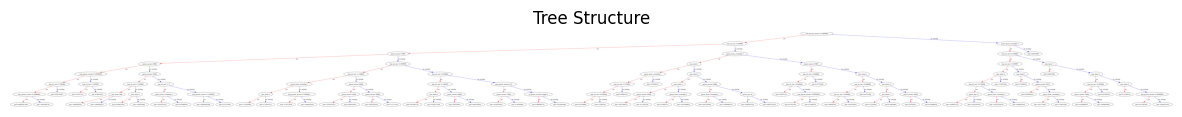

In [42]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 30))  

plot_tree(final_model, num_trees=0, ax=ax)

# Add a title
ax.set_title('Tree Structure')
plt.show()

Get feature importances

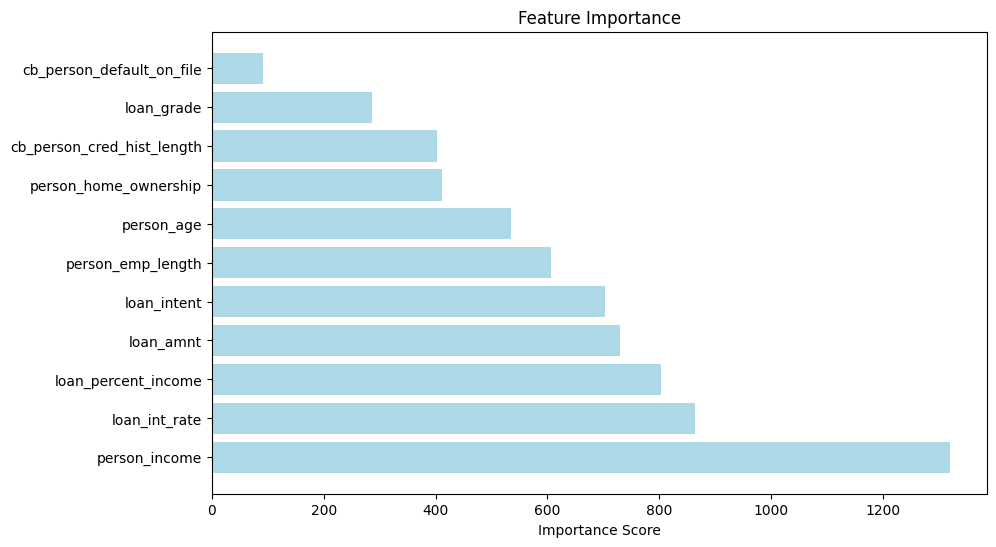

In [ ]:
# Get feature importance
importance = best_xgb.get_booster().get_score(importance_type='weight')

# Sort feature importance
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
features, scores = zip(*importance_sorted)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='lightblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()

__Cross-Validation__

In [ ]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")

Cross-Validation F1 Scores: [0.80283592 0.81144781 0.81137124 0.82617317 0.81672241]
Mean F1 Score: 0.8137101089005754


__Interpretation__
- The mean F1 score of approximately 0.814 indicates solid performance and suggests that the model has good balance between precision and recall across the cross-validation folds.
- The scores show slight variation, but they are generally consistent, indicating that the model is stable and not overly sensitive to the particular training/testing splits used in cross-validation.

## Apply the final model to testing dataset       

In [43]:
# Load the test data
test_data = pd.read_csv('test.csv')

test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


Preprocessing X-test

In [44]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [45]:
test_data.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [46]:
test_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [47]:

# Fit label encoders for categorical columns
label_encoders = {}

for col in test_data[['person_home_ownership', 'loan_intent', 'loan_grade','cb_person_default_on_file']].columns:
    le = LabelEncoder()
    test_data[col] = le.fit_transform(test_data[col])
    label_encoders[col] = le  

In [48]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,3,3.0,2,5,25000,15.76,0.36,0,2
1,58646,26,96000,0,6.0,4,2,10000,12.68,0.10,1,4
2,58647,26,30000,3,5.0,5,4,4000,17.19,0.13,1,2
3,58648,33,50000,3,4.0,0,0,7000,8.90,0.14,0,7
4,58649,26,102000,0,8.0,2,3,15000,16.32,0.15,1,4


In [49]:
test_data_predict = test_data.drop(columns=['id'])

In [50]:
test_data_predict.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,3,3.0,2,5,25000,15.76,0.36,0,2
1,26,96000,0,6.0,4,2,10000,12.68,0.10,1,4
2,26,30000,3,5.0,5,4,4000,17.19,0.13,1,2
3,33,50000,3,4.0,0,0,7000,8.90,0.14,0,7
4,26,102000,0,8.0,2,3,15000,16.32,0.15,1,4


In [51]:
predictions = final_model.predict(test_data_predict)
predictions_df = pd.DataFrame({'Predicted': predictions})


In [52]:
output = pd.concat([test_data[['id']], predictions_df], axis=1)


In [53]:
output.head()

,id,Predicted
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


In [55]:
output.to_csv('submission.csv', index=False)